# Sentinel-2データの読み込み

## 1. Google Colaboratryのマウント処理

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 任意のディレクトリに移動
%cd /content/drive/'My Drive'/'sentinel-2'

/content/drive/My Drive/sentinel-2


## 2. 使用パッケージのインストール
今回使用する以下のパッケージをインストール
 - rasterio: 地理データを扱う
 - geojson: GeoJsonファイルを使用する
 - geopandas: 地理情報をデータフレーム化する

In [ ]:
!pip install rasterio
!pip install geojson
!pip install geopandas

In [ ]:
# 使用パッケージのインポート
import os
import json
import zipfile
import folium
from geojson import Polygon
import rasterio as rio
import rasterio.mask
import fiona
import geopandas as gpd
from rasterio.plot import show
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline

## 3. 検索範囲の指定
Sentinel-2のデータを全て表示するには、非常に時間がかかる。  
そのため、今回はSentine-2データ内の気になる範囲を抜き出す。

In [ ]:
from IPython.display import HTML
HTML(r'<iframe src="https://www.keene.edu/campus/maps/tool/" width="960" height="480" frameborder="0">')

指定した範囲を以下に貼り付け

In [ ]:
AREA = [
      [
        140.5784708,
        36.0220803
      ],
      [
        140.6121164,
        35.9643025
      ],
      [
        140.6677347,
        35.9798622
      ],
      [
        140.636149,
        36.0370734
      ],
      [
        140.5784708,
        36.0220803
      ]
  ]

指定した範囲のGeoJsonファイルを作成する。

In [ ]:
# ファイル名を定義
m = Polygon([AREA])
object_name = "sentinel2_aoi"

# 範囲指定をするGeoJsonファイルを定義
with open(object_name+".geojson", "w") as f:
  json.dump(m, f)

作成したGeoJsonファイルを確認する。

In [ ]:
# 定義した領域が合っているかを確認
m = folium.Map([(AREA[0][1] + AREA[len(AREA)-1][1])/2, (AREA[0][0]+AREA[len(AREA)-1][0])/2], zoom_start=10)

folium.GeoJson(object_name+".geojson").add_to(m)
m

## 4. Sentinel-2データの読み込み

In [ ]:
# Sentinel-2データの格納場所とファイル名を定義
sentinel_dir = "./TIF"
product_name = "S2A_MSIL1C_20211024T012731_N0301_R074_T54SVE_20211024T030447"

# zipファイルの解凍処理
zip_path = os.path.join(sentinel_dir, product_name+'.zip')
with zipfile.ZipFile(zip_path) as zf:
  zf.extractall()

ファイルパスを指定し、各バンドごとにファイルを読み込む。

In [ ]:
# ファイルパスの指定
path_A = str(product_name) + ".SAFE/GRANULE"
files_A = os.listdir(path_A)

path_B = str(product_name) + ".SAFE/GRANULE/" + str(files_A[0])
files_B = os.listdir(path_B)

path_C = str(product_name) + ".SAFE/GRANULE/" + str(files_A[0]) + "/IMG_DATA/" 
files_C = os.listdir(path_C)

# 各バンドごとに読み込む
b2 = rio.open(str(product_name) + '.SAFE/GRANULE/' + str(files_A[0]) + '/IMG_DATA/' + str(files_C[0][0:23] + 'B02.jp2'))
b3 = rio.open(str(product_name) + '.SAFE/GRANULE/' + str(files_A[0]) + '/IMG_DATA/' + str(files_C[0][0:23] + 'B03.jp2'))
b4 = rio.open(str(product_name) + '.SAFE/GRANULE/' + str(files_A[0]) + '/IMG_DATA/' + str(files_C[0][0:23] + 'B04.jp2'))


画像データを出力する前に、サンプルファイルを作成する。

In [ ]:
# サンプルTIFファイルの作成
RGB_path = 'sentinel-2_' + str(files_C[0][7:15]) + '_RGB.tif'

RGB_color = rio.open(RGB_path, 'w', driver='Gtiff',
                       width=b4.width, height=b4.height, count=3,
                       crs=b4.crs, transform=b4.transform,
                       dtype=rasterio.uint16)

RGB_color.write(b2.read(1), 3)
RGB_color.write(b3.read(1), 2)
RGB_color.write(b4.read(1), 1)
RGB_color.close()

## 5. 画像の書き出し処理

In [ ]:
# マスク処理の実施
out_geojson = object_name+".geojson"

nReserve_geo = gpd.read_file(out_geojson)
epsg = b4.crs
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

with rasterio.open(RGB_path) as src:
  out_image, out_transform = rasterio.mask.mask(src, nReserve_proj.geometry, crop=True)
  out_meta = src.meta
  
out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
  
with rasterio.open(RGB_path, "w", **out_meta) as dest:
  dest.write(out_image)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# 画像表示のため8bit形式で書き出し
scale = '-scale 0 255 0 15'
options_list = ['-ot Byte', '-of Gtiff', scale]
options_string = " ".join(options_list)  

gdal.Translate(os.path.join('sentinel-2_'+str(files_C[0][7:15])+'.tif'),os.path.join('sentinel-2_'+str(files_C[0][7:15])+'_RGB.tif'),options = options_string)

print("Done")

Done


## 6. 画像の表示

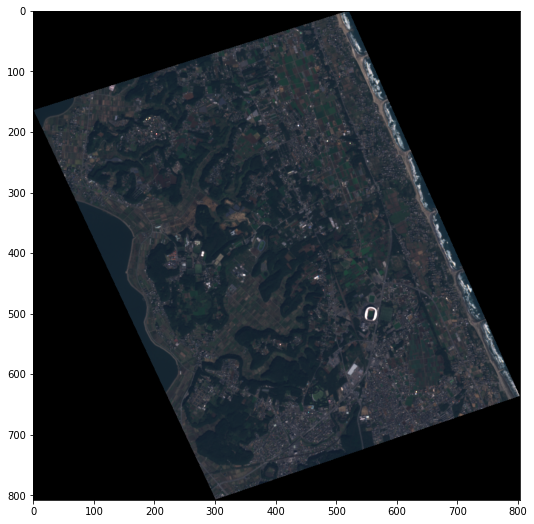

In [ ]:
# 画像の表示
RGB_image1 = rio.open('sentinel-2_'+str(files_C[0][7:15])+'.tif')

plt.figure(figsize=(18, 9))
show(RGB_image1.read([1, 2, 3]))
plt.show()